(array([[<AxesSubplot:title={'center':'steering'}>]], dtype=object),
             throttle       steering
 count  118577.000000  118577.000000
 mean        0.604110      -0.007236
 std         0.345911       0.094685
 min         0.000000      -0.640327
 25%         0.466233      -0.068903
 50%         0.588960      -0.006032
 75%         1.000000       0.061620
 max         1.000000       0.733144)

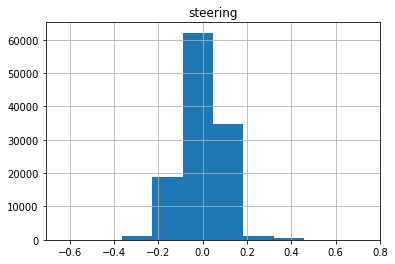

In [8]:
throttles, steerings = [], []
for st_path in veh_state_paths:
    array = np.load(st_path)
    throttles.append(array[-2])
    steerings.append(array[-1])
df = pd.DataFrame(
    data={"throttle":throttles, "steering":steerings}
)
df.hist("steering"), df.describe()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import torch.utils.data as data
import matplotlib.pyplot as plt


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from torchnet.meter import AverageValueMeter
import torch.backends.cudnn as cudnn

In [ ]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data/output")
center_depth_dir = data_dir / "front_depth"
veh_state_dir = data_dir / "vehicle_state"

center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]
print(f"Found { len(center_depth_paths)} data points")

In [ ]:
from utils import depth2colorjet, random_flip, crop_roi, depthToLogDepth
import cv2
class CarDataset(data.Dataset):
    def __init__(self, X, y, img_width=64, img_height=64, should_take_roi=False, roi_min_height=30,
                 should_use_log_depth=True, should_stack=False, resize=None):
        self.X = X
        self.y = y
        self.img_width=img_width
        self.img_height=img_height
        self.should_take_roi = should_take_roi
        self.roi_min_height = roi_min_height
        self.should_use_log_depth=should_use_log_depth
        self.should_stack = should_stack
        self.resize = resize
        
    def __getitem__(self, index):
        img_path = self.X[index]
        veh_state_path = self.y[index]
        steering_angle = np.load(veh_state_path)[-1]
        img = np.load(img_path)
        if self.should_take_roi: # will not enter
            img = img[30:self.img_width, :]
        if self.should_use_log_depth:
            img = depthToLogDepth(img)
        if self.resize is not None:
            img = cv2.resize(img, (self.resize))
        
        # generate random noise to the image
        img, steering_angle = random_flip(img, steering_angle)
        return img, steering_angle
    
    def __len__(self):
        return len(self.X)

    

In [ ]:
car_dataset = CarDataset(X=center_depth_paths, y=veh_state_paths)

In [ ]:
color_jet_depth, angle = car_dataset[100]
print(np.shape(color_jet_depth))
plt.imshow(color_jet_depth), angle

### Use monte carlo method to understand our distribution

In [ ]:
def describe_loader(loader, N=100):
    i = 0
    loader_generator = iter(loader)
    steerings = []
    while i < N:
        img, steering = next(loader_generator)
        angles = steering.numpy()
        for angle in angles:
            steerings.append(angle)
        i += 1
    df = pd.DataFrame(
        data={"steering":steerings}
    )
    df.hist("steering"), df.describe()

## Split data into Train and valid sets

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(center_depth_paths, 
                                                      veh_state_paths, 
                                                      test_size=0.25, 
                                                      shuffle=True)


In [ ]:
batch_size = 2
car_train_loader = DataLoader(CarDataset(X=X_train, y=y_train,resize=(80,60)), 
                              batch_size=batch_size, shuffle=True)
car_valid_loader = DataLoader(CarDataset(X=X_valid, y=y_valid,resize=(80,60)), 
                              batch_size=batch_size, shuffle=True)
describe_loader(car_train_loader)

In [ ]:
print(len(car_train_loader), len(car_valid_loader))

In [ ]:
from model import CarModel


In [ ]:
def toTensor(data, use_cuda, device=None):
    img, target = data
#     img, target = torch.from_numpy(img).float(), torch.from_numpy(np.array([target])).float()
    img = img.float()
    target = target.float()
    if use_cuda:
        img, target = img.to(device), target.to(device)
    return img, target

In [ ]:
best_loss = 1000000

def train(epoch, net, train_loader, optimizer, criterion, use_cuda, 
          device=None, save_dir=Path("."),MAX_BATCH=1000):
    net.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        img, steering_angle = toTensor(data, use_cuda, device)
        output = net(img) # Tensor([ITEM])
        loss = criterion(output, steering_angle)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        if batch_idx % 100 == 0:
            print(f'    Batch: {batch_idx} --> Loss: {train_loss / (batch_idx+1)}') 
        
        if batch_idx >= MAX_BATCH:
            break
    

def valid(epoch, net, validloader, criterion, use_cuda, device=None, save_dir=Path("."),MAX_BATCH=1000):
    global best_loss
    net.eval()
    valid_loss = 0 
    for batch_idx, data in enumerate(validloader):
        img, steering_angle = toTensor(data, use_cuda, device)
        outputs = net(img)
        loss = criterion(outputs, steering_angle)
        valid_loss += loss.data.item()
        
        avg_valid_loss = valid_loss / (batch_idx + 1)
        if batch_idx % 100 == 0:
            print(f"    Valid Loss: {avg_valid_loss}" )
        
        if avg_valid_loss <= best_loss:
            best_loss = avg_valid_loss
            print(f"         Saving.... Best epoch: {epoch} -> {avg_valid_loss}")
            torch.save(net, save_dir / "best_model.h5")
        
        if batch_idx >= MAX_BATCH:
            break
    
    torch.save(net, save_dir / "model.h5")


In [ ]:
#load the previous net or use new net
# net = torch.load("/home/michael/Desktop/projects/ROAR/misc/data/best_model.h5")
# net.training = True

net = CarModel(batch_size=batch_size)


In [ ]:
optimizer = optim.Adam(net.parameters(), lr=1e-5)
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

In [ ]:
save_dir = Path("./data")
save_dir.mkdir(exist_ok=True, parents=True)
if use_cuda:
    net.to(device)
for epoch in range(0, 100):
    print(f"Epoch {epoch}")
    train(epoch, net, car_train_loader, optimizer, criterion, use_cuda, device=device, save_dir=save_dir, 
          MAX_BATCH=len(car_train_loader) // 4)
    valid(epoch, net, car_valid_loader, criterion, use_cuda, device=device, save_dir=save_dir, MAX_BATCH=1000)